# Binary Classification for patient's smoking status
Overview: https://www.kaggle.com/competitions/playground-series-s3e24/overview


## 0) Intro -  Objective 


Your Goal: For this Episode of the Series, your task is to use binary classification to predict a patient's smoking status given information about various other health indicators. Good luck!

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.


## 1) Import of packages

In [42]:
import numpy as np # linear algebra
import optuna
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import ElasticNet,SGDRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import QuantileTransformer

from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from feature_engine.encoding import OneHotEncoder
pd.set_option('mode.chained_assignment', None)

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


pd.set_option('display.max_rows', None)

#!pip install -U seaborn

data/test.csv
data/train.csv


## 1) Load the data and check structure

In [169]:
train_data = pd.read_csv("data/train.csv", index_col='id')
test_data = pd.read_csv("data/test.csv", index_col='id')

train_data_original = pd.read_csv("data/train_dataset_original.csv")
test_data_original = pd.read_csv("data/test_dataset_original.csv")

print("Shapes before merge", train_data.shape, train_data_original.shape)

### Let's append the original data to this dataset to see if it improves results
train_data = pd.concat([train_data, train_data_original],axis = 0).reset_index(drop=True)

Shapes before merge (159256, 23) (38984, 23)


In [170]:
train_data.head()


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1


#### All numerical variables

In [173]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198240 entries, 0 to 198239
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  198240 non-null  int64  
 1   height(cm)           198240 non-null  int64  
 2   weight(kg)           198240 non-null  int64  
 3   waist(cm)            198240 non-null  float64
 4   eyesight(left)       198240 non-null  float64
 5   eyesight(right)      198240 non-null  float64
 6   hearing(left)        198240 non-null  int64  
 7   hearing(right)       198240 non-null  int64  
 8   systolic             198240 non-null  int64  
 9   relaxation           198240 non-null  int64  
 10  fasting blood sugar  198240 non-null  int64  
 11  Cholesterol          198240 non-null  int64  
 12  triglyceride         198240 non-null  int64  
 13  HDL                  198240 non-null  int64  
 14  LDL                  198240 non-null  int64  
 15  hemoglobin       

#### Original data https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals

## 3) Discover and visualize data to gain insights

##### No missing data

In [174]:
train_data.isnull().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [175]:
test_data.isnull().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
dtype: int64

In [176]:
train_data.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,...,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000
mean,44.271418,165.153375,66.906709,82.817163,1.007599,1.002519,1.024248,1.023966,122.301488,76.701085,...,56.135951,114.700858,14.763003,1.076650,0.891440,25.650847,26.667282,36.941455,0.201226,0.423583
std,11.886308,8.895587,12.656868,9.039363,0.422827,0.414241,0.153820,0.152943,12.920634,9.135720,...,14.106668,31.601535,1.460424,0.359204,0.188198,12.014495,21.119268,35.637177,0.400917,0.494127
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,...,4.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,77.000000,0.800000,0.800000,1.000000,1.000000,113.000000,70.000000,...,46.000000,94.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,77.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,23.000000,22.000000,27.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,65.000000,134.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,233.000000,146.000000,...,359.000000,1860.000000,21.100000,6.000000,11.600000,1090.000000,2914.000000,999.000000,1.000000,1.000000


#### Smoking patients are almost half of the train data

In [177]:
train_data.smoking.value_counts()

0    114269
1     83971
Name: smoking, dtype: int64

In [178]:
train_data.smoking.value_counts()[0]

114269

In [179]:
negative_def = train_data.smoking.value_counts()[0]/len(train_data.smoking)
positive_def = 1 - negative_def
class_weights = {0: negative_def, 1: positive_def}
class_weights

{0: 0.5764174737691686, 1: 0.42358252623083137}

### Plot features distribution

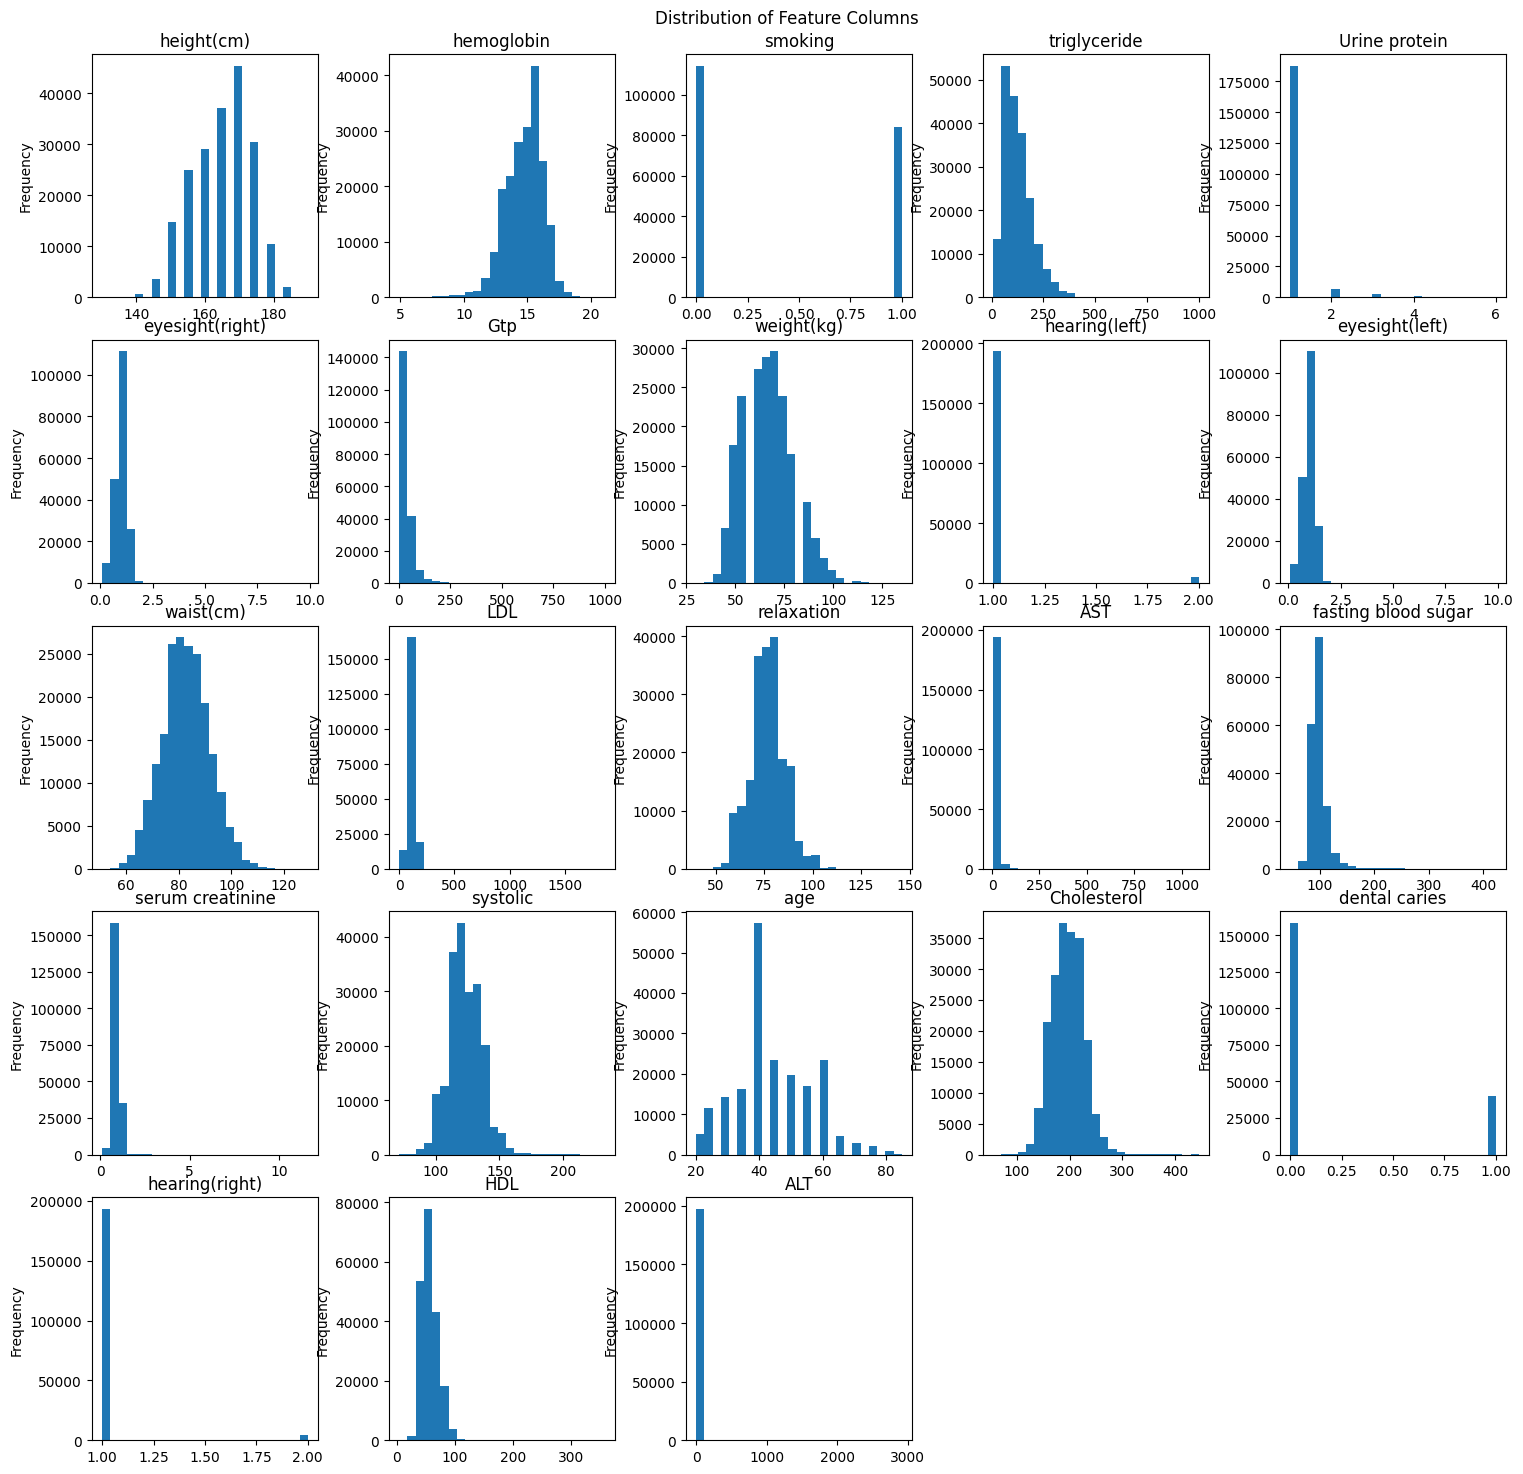

In [180]:
def plot_features_distribution(df):

    feature_columns = set(df.columns)-set(["defects"])

    # Define the number of rows and columns for subplots
    num_rows = (len(feature_columns) + 4) // 5
    num_cols = min(len(feature_columns), 5)

    # Create subplots
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.90, bottom=0.3)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Iterate through feature columns and plot their distributions
    for i, col in enumerate(feature_columns):
        row = i // num_cols
        col_num = i % num_cols
        ax = axes[row, col_num]

        # Plot the distribution
        df[col].plot(kind='hist', ax=ax, bins=25, title=col)
        ax.set_ylabel('Frequency')

    # If there are empty subplots, remove them
    for i in range(len(feature_columns), num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    # Add a title to the overall picture
    plt.suptitle("Distribution of Feature Columns")
    # Show the plot
    plt.show()



plot_features_distribution(train_data)


### Correlations

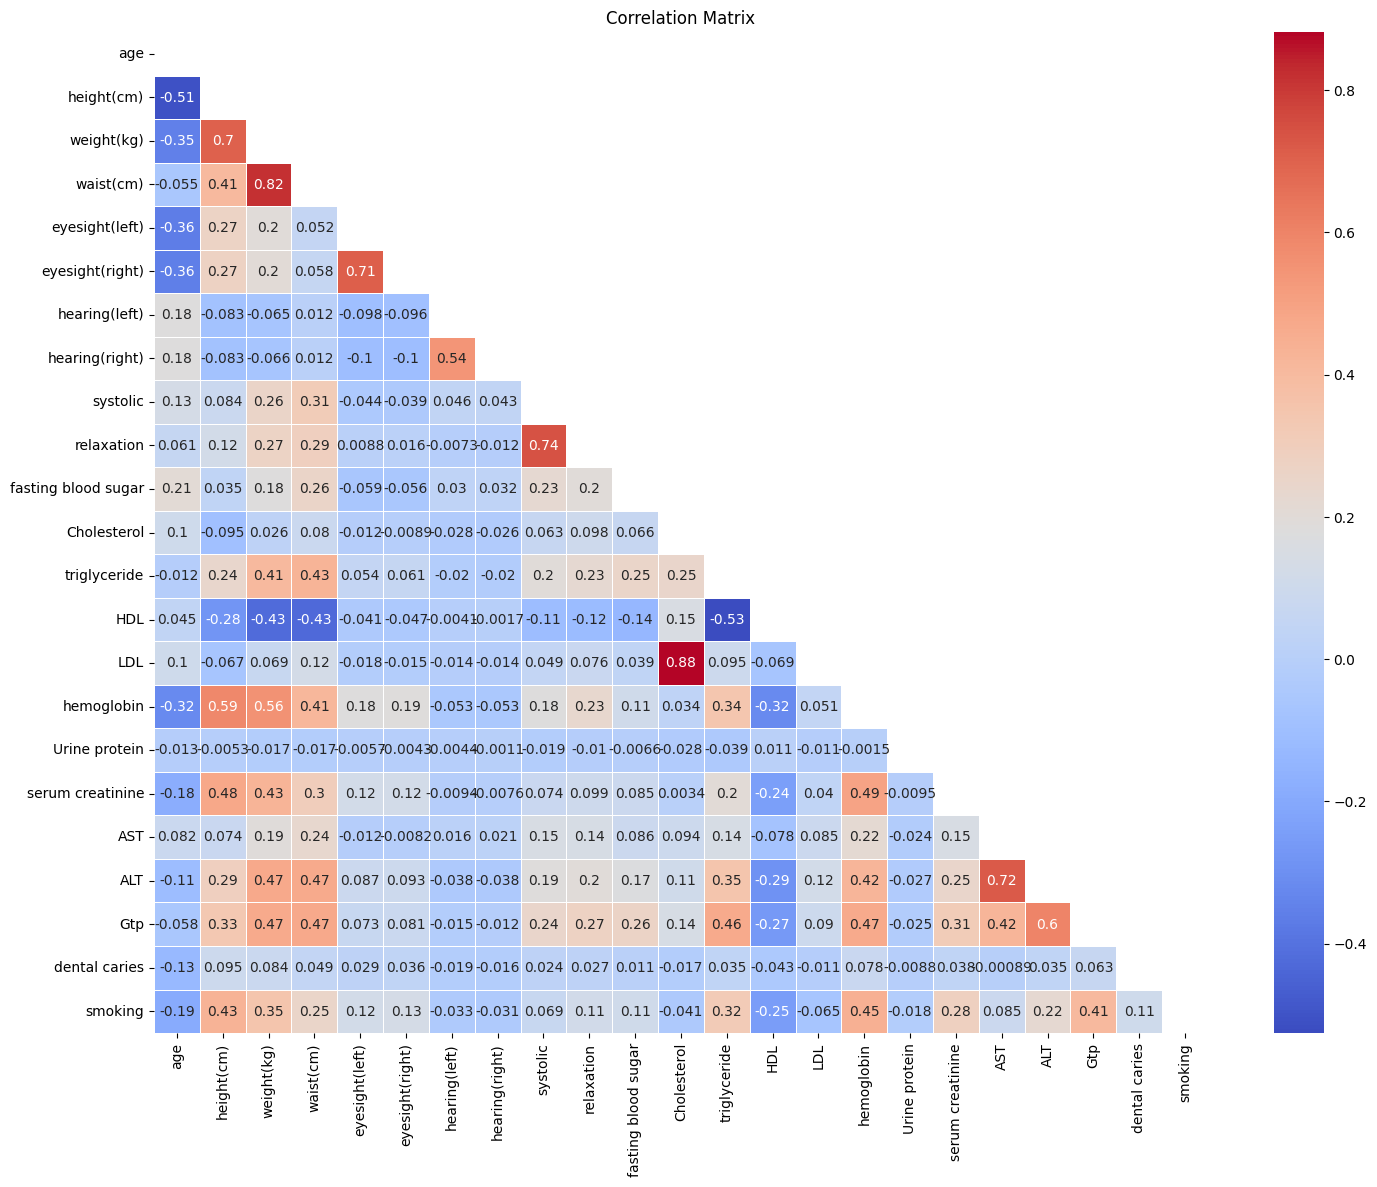

In [97]:
#### Correlation matrix

correlation_matrix = train_data.corr(method="spearman") # To capture non linear correlations
plt.figure(figsize=(17, 13))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


#Relationship: t = e / 18. In the original data, the correlation is perfect. => we can drop t
#Relationship: l = 1 / d => we can drop l

### Observations
Some variables are particularly correlated with smoking:
- height, weight, waist, triglyceride, hemoglobin, Gtp (positively), age and HDL (negatively)
- many variables are normally distributed without transformations

## Feature engineering

In [181]:
FEATURES = list(set(train_data.columns)-set(["smoking"]))
TARGET = 'smoking'  

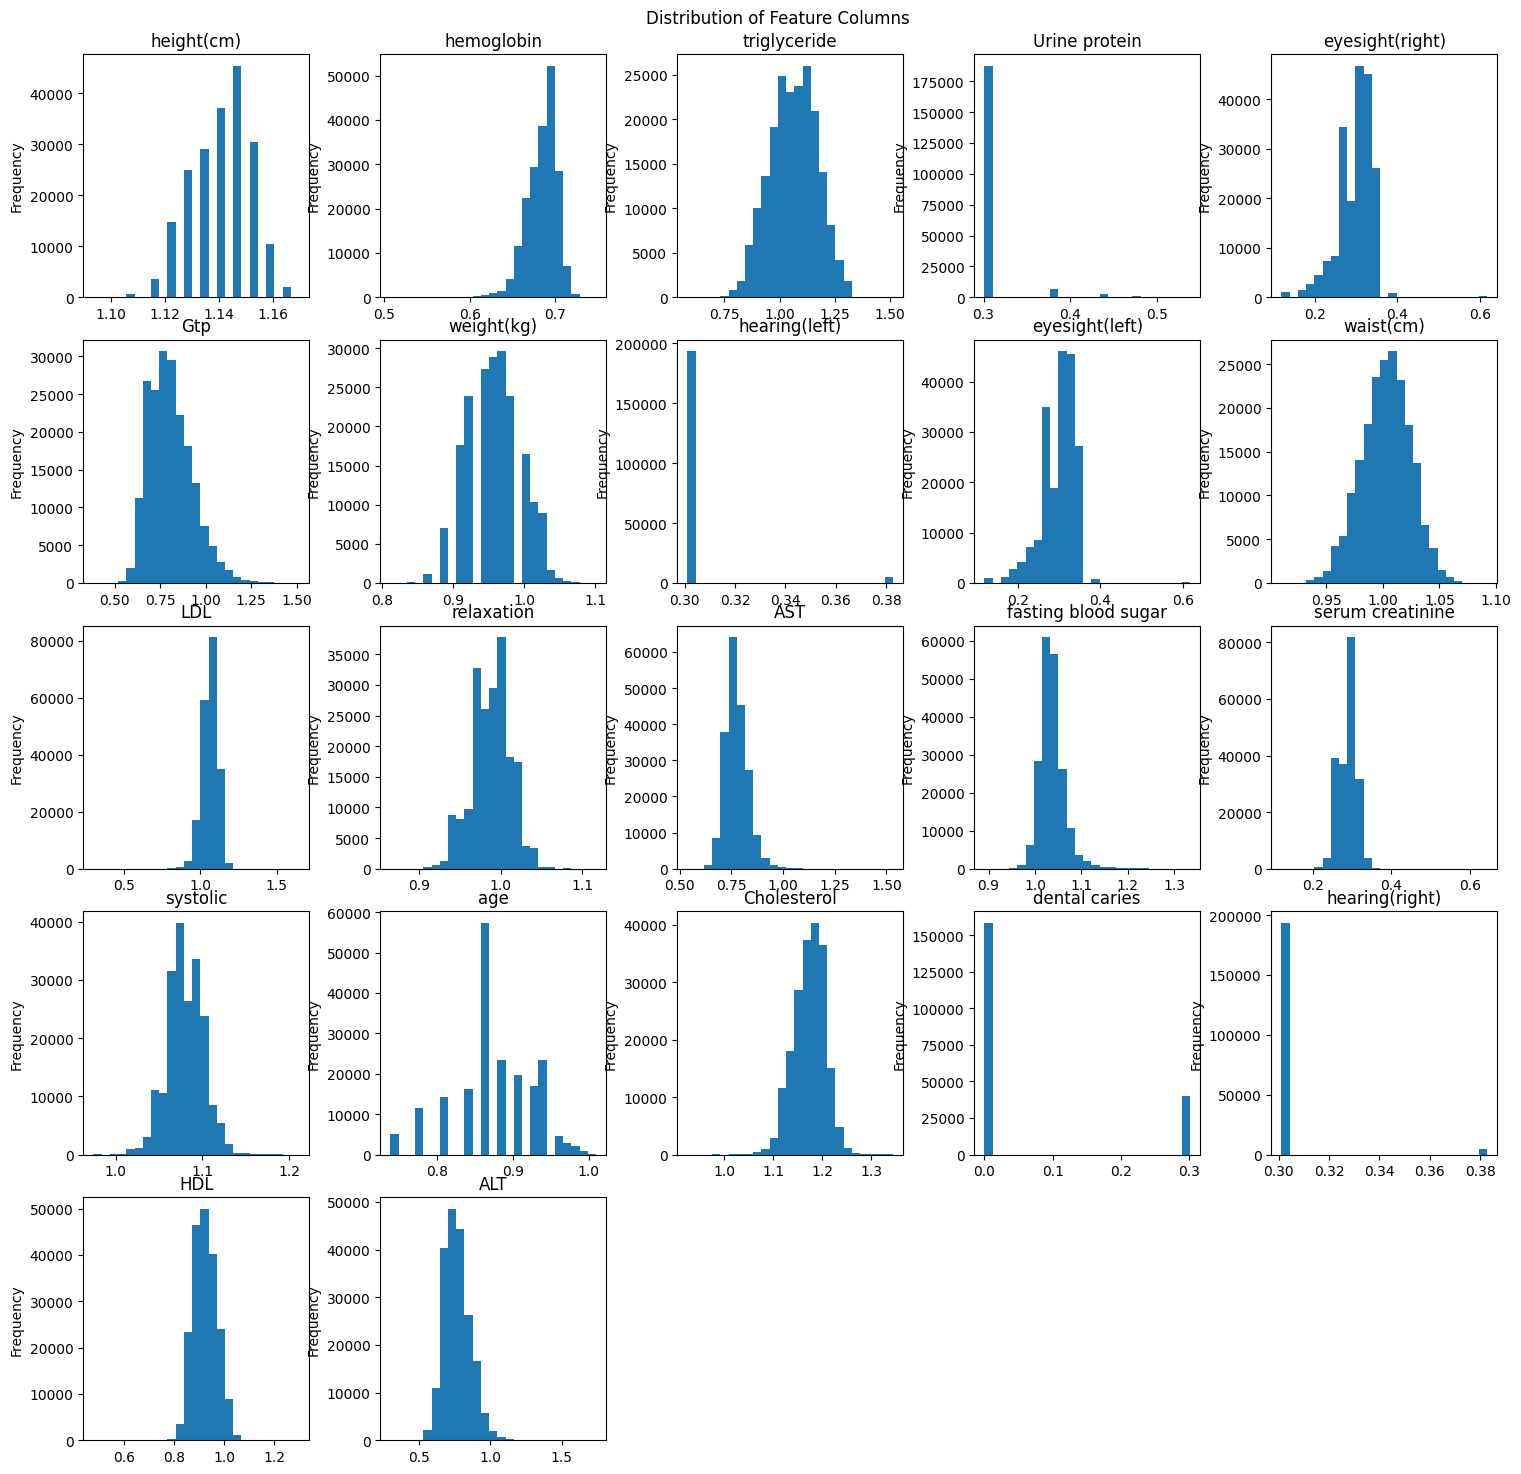

In [182]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import yeojohnson

def edit_X_features(df):
    
    df_new = df.copy()
    df_new = np.sqrt(df_new)
    df_new =  np.log10(df_new+1)
    # df_new = df_new.apply(lambda x: yeojohnson(x)[0])

    # scaler = MinMaxScaler()
    # scaled_data = scaler.fit_transform(df_new)
    # df_new = pd.DataFrame(scaled_data, columns=df_new.columns,  index=df.index)

    return df_new

full_enhanced=  edit_X_features(train_data[FEATURES])
plot_features_distribution(full_enhanced)


## Modelling
Split the data into train and validation set, stratify since dataset is unbalanced

In [183]:
y = train_data.copy()[TARGET].astype(int)

X_test = test_data[FEATURES].copy()
X = edit_X_features(train_data.copy()[FEATURES])

X_test = edit_X_features(X_test)

# Single split
train_X, val_X, train_y, val_y = train_test_split(X,y,stratify=y,test_size=0.1,random_state=0)

### Cross validation strategy

In [184]:
kfold = KFold(n_splits=5,shuffle=True,random_state=0)
skfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

### Simple logistic regression

In [185]:
from sklearn.linear_model import LogisticRegression

def logistic_predictions(train_X, train_y):

    reg = LogisticRegression()
    
    reg.fit(train_X,train_y)
    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    return predictions, reg

log_predictions_val, log_model = logistic_predictions(train_X, train_y)

ROC-AUC score training 0.8306045644297005
ROC-AUC score validation 0.8264838362398803


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### XGB Classifier

#### Single execution

In [186]:
xgb_params = {'objective':'binary:logistic', 
              'n_estimators':120,
              'learning_rate':0.03858856691681774,
              'max_depth':None,
              'gamma':14,
              'scale_pos_weight':negative_def/positive_def,
              'random_state':0}

def XGBoost_predictions(train_X, train_y, val_X, val_y, xgb_params):

    reg = xgb.XGBClassifier(eval_metric  = "mape", **xgb_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    return predictions, reg, val_auc

xgb_predictions_val, xgb_model, xgb_val_auc = XGBoost_predictions(train_X, train_y,val_X, val_y, xgb_params)

#xgb_model.score

ROC-AUC score training 0.8633655322210607
ROC-AUC score validation 0.8559815349923225


#### Analysis of prediction errors

In [108]:
# predictions_df = pd.DataFrame({'id':val_X.index, 'defects_prediction':xgb_predictions_val})
# predictions_df = predictions_df.set_index("id")

# analysis_df = pd.concat([predictions_df, val_X, val_y], axis=1)
# analysis_df["diff_pred"] = analysis_df.defects_prediction-analysis_df.defects
# analysis_df["id"] = analysis_df.index


In [110]:
# def plot_predictions_diff(df):

#     feature_columns = set(df.columns)-set(["defects"])

#     good_pred = df[abs(df.diff_pred)<=0.5]
#     bad_pred = df[abs(df.diff_pred)>0.5]

#     # Define the number of rows and columns for subplots
#     num_rows = (len(feature_columns) + 1) // 2
#     num_cols = min(len(feature_columns), 2)

#     # Create subplots
#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

#     fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.90, bottom=0.3)
#     fig.tight_layout()
#     fig.subplots_adjust(top=0.95)

#     # Iterate through feature columns and plot their distributions
#     for i, col in enumerate(feature_columns):
#         row = i // num_cols
#         col_num = i % num_cols
#         ax = axes[row, col_num]

#         # Plot the distribution
#         good_pred[col].plot(kind='hist', ax=ax, bins=100, title=col)
#         bad_pred[col].plot(kind='hist', ax=ax, bins=100, title=col)

#         #sns.displot(good_pred, x="n", bins=20).set(title='Points by Team')

#         ax.set_ylabel('Frequency')



#     # Add a title to the overall picture
#     plt.suptitle("Distribution of columns - bad, good predictions")
#     # Show the plot
#     plt.show()

In [111]:
# plot_predictions_diff(analysis_df)

##### Observations
- Higher errors seem to appear when certain variables have particularly higher values
- Create some features highlighting problematic observations

In [112]:
# good_pred = analysis_df[abs(analysis_df.diff_pred)<=0.5]
# bad_pred = analysis_df[abs(analysis_df.diff_pred)>0.5]

# threshold_dict ={}
# for col in FEATURES:
#     threshold_dict[col] = bad_pred[col].median()

# threshold_dict


#### Parameter optimization

In [113]:
OPTUNA = False

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def xgb_objective(trial):

        # Set the hyperparameters of the XGBoost classifier.
        params = {'objective':'binary:logistic', 
                  'n_estimators':120,
                  'learning_rate':0.03858856691681774, #trial.suggest_float('learning_rate',0.03,0.3)
                  'max_depth':None,
                  'gamma':trial.suggest_int('gamma',0,15),
                  'scale_pos_weight':negative_def/positive_def,
                  'random_state':0
                 }

        xgb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            xgb_predictions_fold, xgb_model_fold, xgb_val_auc_fold = XGBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params)
            xgb_auc_score_avg += xgb_val_auc_fold
            
        xgb_auc_score_avg /=5
        # print(f'The averaged AUC score evaluated on the validation subset using XGB model:', xgb_auc_score_avg)
        return -xgb_auc_score_avg

    xgb_study = optuna.create_study()
    xgb_study.optimize(xgb_objective, n_trials=10)
    best_xgb_params = xgb_study.best_trial.params

    print('Best XGB hyper parameters:', best_xgb_params)

### Random forest classifier

#### Single execution

In [114]:
rf_params = { 'n_estimators':935,
              'max_depth':10,
              'min_samples_split':3,
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':True,
              'n_jobs' :-1}

def RandomForest_predictions(train_X, train_y, val_X, val_y, rf_params):

    reg = RandomForestClassifier(**rf_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    return predictions, reg, val_auc

random_forest_predictions_val, rf_model, rf_val_auc = RandomForest_predictions(train_X, train_y, val_X, val_y, rf_params)

ROC-AUC score training 0.8702107526502052
ROC-AUC score validation 0.8579874849416896


#### Parameter optimization

In [333]:
OPTUNA = False

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def rf_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        class_weights = {0: 0.773, 1: 0.227}
        params = {'n_estimators':trial.suggest_int('n_estimators',200,1000),
              'max_depth':10,
              'min_samples_split':3,
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':True,
              'n_jobs' :-1}

        rf_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            rf_predictions_fold, rf_model_fold, rf_val_auc_fold = RandomForest_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params)
            rf_auc_score_avg += rf_val_auc_fold
            
        rf_auc_score_avg /=5
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -rf_auc_score_avg

    rf_study = optuna.create_study()
    rf_study.optimize(rf_objective, n_trials=20)
    best_rf_params = rf_study.best_trial.params

    print('Best RF hyper parameters:', best_rf_params)

In [334]:
# optuna.visualization.plot_contour(rf_study)
# optuna.visualization.plot_param_importances(rf_study)

### ExtraTreesClassifier

#### Single Execution


In [116]:
et_params = { 'n_estimators':549,
              'max_depth':16,
              'max_features':'auto',
              'min_samples_split':9,
              'min_samples_leaf':3,
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':False,
              'n_jobs' :-1}

def ExtraTrees_predictions(train_X, train_y, val_X, val_y, et_params):

    reg = ExtraTreesClassifier(**et_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    return predictions, reg, val_auc

extratree_classifier_predictions_val, extratree_model, extrateree_val_auc = ExtraTrees_predictions(train_X, train_y, val_X, val_y, et_params)

ROC-AUC score training 0.8764324320388457
ROC-AUC score validation 0.8541985982468047


#### Parameters optimization

In [336]:
OPTUNA = False

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def extratree_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        class_weights = {0: 0.773, 1: 0.227}
        params = {'n_estimators':trial.suggest_int('n_estimators',100,1000),
              'max_depth':trial.suggest_int('max_depth',1,100),
              'max_features':'auto',
              'min_samples_split':trial.suggest_int('min_samples_split',2,10),
              'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,10),
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':False,
              'n_jobs' :-1}
        
        et_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            et_predictions_fold, et_model_fold, et_val_auc_fold = extratree_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params)
            et_auc_score_avg += et_val_auc_fold
            
        et_auc_score_avg /=5
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -et_auc_score_avg

    et_study = optuna.create_study()
    et_study.optimize(extratree_objective, n_trials=100)
    best_et_params = et_study.best_trial.params

    print('Best Extratree hyper parameters:', best_et_params)

In [337]:
# optuna.visualization.plot_contour(et_study)
# optuna.visualization.plot_param_importances(et_study)


### Logistic regression with Nyström kernel approximation

#### Single Execution

In [117]:
nystroem_params = {'n_components':384}

def nystroem_logistic(train_X, train_y, val_X, val_y, nystroem_params):

    # Standardize the features (optional but recommended)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_X)
    X_test = scaler.transform(val_X)

    # Create a Nystroem feature map
    nystroem = Nystroem(kernel='rbf', **nystroem_params, random_state=42)

    # Apply the feature map to both the training and testing data
    X_train_nystroem = nystroem.fit_transform(X_train)
    X_test_nystroem = nystroem.transform(X_test)

    # Create and train the logistic regression model
    reg = LogisticRegression()
    reg.fit(X_train_nystroem, train_y)

    # Make predictions on the test set
    predictions_train = reg.predict_proba(X_train_nystroem)[:,1]

    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(X_test_nystroem)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    return predictions, reg, val_auc

nystroem_logistic_predictions_val, nystroem_logistic_model, nystroem_val_auc_fold = nystroem_logistic(train_X, train_y, val_X, val_y, nystroem_params)

c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.8481305233850287
ROC-AUC score validation 0.8492506516682133


#### Parameters optimization

In [339]:
OPTUNA = False

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def nystroem_objective(trial):
        params = {'n_components':trial.suggest_int('n_components',50,500)}        
        
        ny_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            ny_predictions_fold, ny_model_fold, ny_val_auc_fold = nystroem_logistic(train_X_fold, train_y_fold, val_X_fold, val_y_fold, params)
            ny_auc_score_avg += ny_val_auc_fold
            
        ny_auc_score_avg /=5
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -ny_auc_score_avg

    ny_study = optuna.create_study()
    ny_study.optimize(nystroem_objective, n_trials=30)
    best_ny_params = ny_study.best_trial.params

    print('Best nystroem logistic hyper parameters:', best_ny_params)

### CatBoostClassifier

#### Single Execution

In [190]:
best_cb_params

{'iterations': 1386,
 'depth': 4,
 'learning_rate': 0.2430249085174812,
 'l2_leaf_reg': 9}

In [191]:
cb_params = { 'iterations': 1386,
            'depth': 4,
            'learning_rate': 0.2430249085174812,
            'l2_leaf_reg': 9,
              'loss_function':'Logloss',
              'verbose':0,
              'random_seed':42,
              'class_weights':class_weights
              }
        
def CatBoost_predictions(train_X, train_y, val_X, val_y, cb_params):

    reg = CatBoostClassifier(**cb_params)    
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    val_auc = roc_auc_score(val_y,predictions)

    return predictions, reg, val_auc

catbost_classifier_predictions_val, catboost_model, catboost_val_auc = CatBoost_predictions(train_X, train_y, val_X, val_y, cb_params)

ROC-AUC score training 0.8978765780742901
ROC-AUC score validation 0.8681816993256842


#### Parameters optimization


In [192]:
OPTUNA = False

optuna.logging.set_verbosity(optuna.logging.WARNING)


if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def catboost_objective(trial):

        # Set the hyperparameters of the Random forest classifier.

        params = {'iterations':trial.suggest_int('iterations',500, 2000),
              'depth':trial.suggest_int('depth',1,10),
              'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
              'l2_leaf_reg':trial.suggest_int('l2_leaf_reg',1,10),
              'loss_function':'Logloss',
              'verbose':0,
              'random_seed':42,
              'class_weights':class_weights
              }
        
        cb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            cb_predictions_fold, cb_model_fold, cb_val_auc_fold = CatBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params)
            cb_auc_score_avg += cb_val_auc_fold
            
        cb_auc_score_avg /=5
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -cb_auc_score_avg

    cb_study = optuna.create_study()
    cb_study.optimize(catboost_objective, n_trials=10, show_progress_bar=True)
    best_cb_params = cb_study.best_trial.params

    print('Best catboost hyper parameters:', best_cb_params)

### LGBMClassifier

#### Single Execution

In [119]:
lgbm_params = { 'boosting_type':'gbdt',
              'num_leaves':17,
              'learning_rate':0.013240041792690652,
              'n_estimators':431,
              'max_depth':-1,
              'random_state':42,
              'class_weight':class_weights
              }

def lgbm_predictions(train_X, train_y, val_X, val_y, lgbm_params):

    reg = lgb.LGBMClassifier(**lgbm_params)    
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    val_auc = roc_auc_score(val_y,predictions)

    return predictions, reg, val_auc

lgbm_classifier_predictions_val, lgbm_model, lgbm_val_auc= lgbm_predictions(train_X, train_y, val_X, val_y, lgbm_params)

ROC-AUC score training 0.8568725011440652
ROC-AUC score validation 0.8556001449458257


#### Parameters optimization

In [343]:
OPTUNA = False

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def lgbm_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        class_weights = {0: 0.773, 1: 0.227}    
     
        params = { 'boosting_type':'gbdt',
              'num_leaves':trial.suggest_int('num_leaves',10, 200),
              'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
              'n_estimators':trial.suggest_int('n_estimators',100, 2000),
              'max_depth':-1,
              'random_state':42,
              'class_weight':class_weights
              }
        
        lgbm_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            lgbm_predictions_fold, lgbm_model_fold, lgbm_val_auc_fold = lgbm_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params)
            lgbm_auc_score_avg += lgbm_val_auc_fold
            
        lgbm_auc_score_avg /=5
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -lgbm_auc_score_avg

    lgbm_study = optuna.create_study()
    lgbm_study.optimize(lgbm_objective, n_trials=100)
    best_lgbm_params = lgbm_study.best_trial.params

    print('Best lgbm hyper parameters:', best_lgbm_params)

### HistGradientBoostingClassifier

#### Single Execution

In [120]:
hgbc_params =  {'max_iter': 477, 
                'learning_rate': 0.04584446359126259, 
                'max_depth': 3, 
                'l2_regularization': 0.0822627761827129, 
                'random_state':42,}

def hgbc_predictions(train_X, train_y, val_X, val_y, hgbc_params):

    reg = HistGradientBoostingClassifier(**hgbc_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    return predictions, reg, val_auc

hgbc_classifier_predictions_val, hgbc_model, hgbc_val_auc = hgbc_predictions(train_X, train_y, val_X, val_y, hgbc_params)

ROC-AUC score training 0.8606269398667759
ROC-AUC score validation 0.859112773145123


#### Parameter optimization

In [345]:
OPTUNA = False

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def hgbc_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        class_weights = {0: 0.773, 1: 0.227}    
           
        params = {
            'max_iter':trial.suggest_int('max_iter',1, 1000),
            'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
            'max_depth':trial.suggest_int('max_depth',1, 100),
            'random_state':42,
            'l2_regularization':trial.suggest_float('l2_regularization',0, 0.1),
              }
        
        hgbc_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            hgbc_predictions_fold, hgbc_model_fold, hgbc_val_auc_fold = hgbc_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params)
            hgbc_auc_score_avg += hgbc_val_auc_fold
            
        hgbc_auc_score_avg /=5
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -hgbc_auc_score_avg

    hgbc_study = optuna.create_study()
    hgbc_study.optimize(hgbc_objective, n_trials=100)
    best_hgbc_params = hgbc_study.best_trial.params

    print('Best hgbc hyper parameters:', best_hgbc_params)

### Neural network

#### Single Execution

In [121]:
nn_params =  {"hidden_layer_sizes":(20, 10, 10, 5), 
              "activation":'relu', 
              "max_iter":2000, 
              "random_state":42}

def neural_network_classifier(train_X, train_y, val_X, val_y, nn_params):
    # Create an MLPClassifier (Multi-layer Perceptron) neural network
    # You can customize the architecture by adjusting the hidden_layer_sizes and other parameters.
    reg = MLPClassifier(**nn_params)

    # Train the model
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)
    
    return predictions, reg, val_auc

nn_classifier_predictions_val, nn_model, nn_val_auc = neural_network_classifier(train_X, train_y, val_X, val_y, nn_params)

ROC-AUC score training 0.8431913867408622
ROC-AUC score validation 0.8439277530323007


## Check AUC-ROC

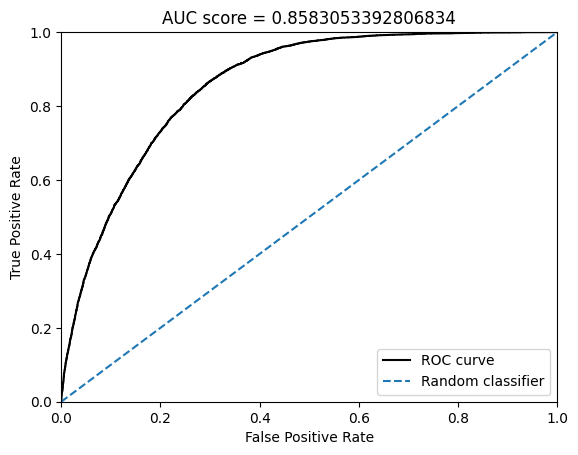

In [122]:
def plot_roc(val_y,pred_y):
    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(val_y,pred_y, pos_label=1)

    plt.plot(fpr, tpr, 'k', label='ROC curve')

    # Plot the baseline
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')

    # Set the axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Set axis limits
    plt.xlim(0,1)
    plt.ylim(0,1)

    # Set the title
    plt.title('AUC score = ' + str(roc_auc_score(val_y,pred_y)))

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()
    
plot_roc(val_y,xgb_predictions_val)
# plot_roc(val_y,random_forest_predictions)
# plot_roc(val_y,extratree_classifier_predictions)
# plot_roc(val_y,log_predictions)

### Rank models by performance

In [124]:
val_predictions_roc = {'xgb':roc_auc_score(val_y,xgb_predictions_val),
                       'rf':roc_auc_score(val_y,random_forest_predictions_val),
                       'extratree':roc_auc_score(val_y,extratree_classifier_predictions_val),
                       'log':roc_auc_score(val_y,log_predictions_val),
                       'lgbm':roc_auc_score(val_y,lgbm_classifier_predictions_val),
                       'catboost':roc_auc_score(val_y,catbost_classifier_predictions_val),
                       'hgbc':roc_auc_score(val_y,hgbc_classifier_predictions_val),
                       'nystroem':roc_auc_score(val_y,nystroem_logistic_predictions_val),     
                       'neural':roc_auc_score(val_y,nn_classifier_predictions_val),     
                       }

val_predictions_roc = sorted(val_predictions_roc.items(), key=lambda x:x[1],  reverse=True)
val_predictions_roc


[('catboost', 0.8651450894212145),
 ('hgbc', 0.859112773145123),
 ('xgb', 0.8583053392806834),
 ('rf', 0.8579874849416896),
 ('lgbm', 0.8556001449458257),
 ('extratree', 0.8541985982468047),
 ('nystroem', 0.8492506516682133),
 ('neural', 0.8439277530323007),
 ('log', 0.8251487143849183)]

### Optimize weights for the ensamble with Optuna (on initial validation set)

In [195]:
ensamble_weights = [0.15, 0.15, 0.15, 0.15, 0.10, 0.05, 0.05, 0.15] ## manual version
model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, nystroem_logistic_predictions_val,
                          hgbc_classifier_predictions_val, lgbm_classifier_predictions_val, random_forest_predictions_val,
                            extratree_classifier_predictions_val, nn_classifier_predictions_val]

ensamble_predictions_val = np.average(model_predictions_val, weights=ensamble_weights, axis=0)
roc_auc_score(val_y,ensamble_predictions_val)

c:\Users\incar\anaconda3\lib\site-packages\numpy\lib\function_base.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


ValueError: operands could not be broadcast together with shapes (19824,) (23723,) 

In [125]:
if False:

  optuna.logging.set_verbosity(optuna.logging.WARNING)

  def ensamble_objective(trial):
    STEP_SIZE = 2

    weights = []
    all_models_predictions = []

    # we'll use a variable for setting upper limit for suggested value
    # since we intend to update it after each weight suggestion
    upper_limit = 100

    w_xgb = trial.suggest_int("w_xgb", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_xgb)

    upper_limit -= w_xgb
    upper_limit = upper_limit

    w_catboost = trial.suggest_int("w_catboost", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_catboost)

    upper_limit -= w_catboost
    upper_limit = upper_limit

    w_nystroem = trial.suggest_int("w_nystroem", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_nystroem)

    upper_limit -= w_nystroem
    upper_limit = upper_limit

    w_hgbc = trial.suggest_int("w_hgbc", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_hgbc)

    upper_limit -= w_hgbc
    upper_limit = upper_limit

    w_lgbm = trial.suggest_int("w_lgbm", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_lgbm)

    upper_limit -= w_lgbm
    upper_limit = upper_limit

    w_rf = trial.suggest_int("w_rf", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_rf)

    # w_extratree = 100 - sum(weights)
    # weights.append(w_extratree)

    w_extratree = trial.suggest_int("w_extratree", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_extratree)

    w_neural = trial.suggest_int("w_neural", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_neural)

    # Just as a sanity check, we'll check that the sum of all weights is equal to 100
    weights_sum = sum(weights)
    # if weights_sum != 100:
    #   raise Exception(f"Weights sum must be equal to 100. Instead {weights_sum} was encountered!")
    
    model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, nystroem_logistic_predictions_val, hgbc_classifier_predictions_val, 
                            lgbm_classifier_predictions_val, random_forest_predictions_val, extratree_classifier_predictions_val,nn_classifier_predictions_val]

    ensamble_predictions_val = np.average(model_predictions_val, weights=weights, axis=0)
    auroc_ensamble_avg = roc_auc_score(val_y,ensamble_predictions_val)

    return -auroc_ensamble_avg


  ensamble_study = optuna.create_study(study_name="optimizing weights")
  ensamble_study.optimize(ensamble_objective, n_trials=2000, show_progress_bar=True)

  best_ensamble_params = ensamble_study.best_trial.params

  print('Best ensamble weights:', best_ensamble_params)

  # best_ensamble_params["w_extratree"]=100-sum(best_ensamble_params.values())

  best_ensamble_params


In [126]:
# Manual ensamble_weights = [0.15, 0.15, 0.15, 0.15, 0.10, 0.05, 0.05, 0.15] ## manual version

# best_ensamble_params = {'w_xgb': 15,
#  'w_catboost': 15,
#  'w_nystroem': 15,
#  'w_hgbc': 15,
#  'w_lgbm': 10,
#  'w_rf': 5,
#  'w_extratree': 5,
#  'w_neural':15}

best_ensamble_params

{'w_xgb': 0,
 'w_catboost': 100,
 'w_nystroem': 0,
 'w_hgbc': 0,
 'w_lgbm': 0,
 'w_rf': 0,
 'w_extratree': 0,
 'w_neural': 0}

## Final Prediction for test set

In [193]:
xgb_predictions = xgb_model.predict_proba(X_test)[:,1]
random_forest_predictions = rf_model.predict_proba(X_test)[:,1]
extratree_classifier_predictions = extratree_model.predict_proba(X_test)[:,1]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_X.copy())
X_test_scaled = scaler.transform(X_test.copy())
n_components = nystroem_params["n_components"] 
nystroem = Nystroem(kernel='rbf', n_components=n_components, random_state=42)
X_train_nystroem = nystroem.fit_transform(X_train_scaled)
X_test_nystroem = nystroem.transform(X_test_scaled)
nystroem_logistic_predictions = nystroem_logistic_model.predict_proba(X_test_nystroem)[:,1]

catbost_classifier_predictions = catboost_model.predict_proba(X_test)[:,1]
lgbm_classifier_predictions = lgbm_model.predict_proba(X_test)[:,1]
hgbc_classifier_predictions = hgbc_model.predict_proba(X_test)[:,1]
nn_classifier_predictions = nn_model.predict_proba(X_test)[:,1]


# final_prediction = 0.20 * xgb_predictions + \
#                    0.15 * catbost_classifier_predictions + \
#                    0.20 * nystroem_logistic_predictions + \
#                    0.15 * hgbc_classifier_predictions + \
#                    0.20 * lgbm_classifier_predictions + \
#                    0.05 * random_forest_predictions + \
#                    0.05 * extratree_classifier_predictions

#final_prediction = lgbm_classifier_predictions

model_predictions_test = [xgb_predictions, catbost_classifier_predictions, nystroem_logistic_predictions, 
                          hgbc_classifier_predictions, lgbm_classifier_predictions, random_forest_predictions, 
                          extratree_classifier_predictions, nn_classifier_predictions]

final_prediction = np.average(model_predictions_test, weights=list(best_ensamble_params.values()), axis=0)


# Save predicted results to the competition submission format.
submission = pd.DataFrame({'id':test_data.index, TARGET:final_prediction})
submission = submission.set_index(keys="id")
submission.head(3)

,smoking
id,
159256,0.524050
159257,0.159369
159258,0.201172


### Submit predictions

In [194]:
submission.to_csv('submissions/3.ensamble_catboost_optuna_plus_original_optimized.csv')

### Voting classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
X_test = test_data.copy()
X_test = X_test[FEATURES]
X_test = edit_X_features(X_test)

voting_models = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model),
    # ('ny', nystroem_logistic_model),
    ('et', extratree_model),
    ('cb', catboost_model),
    ('lgbm', lgbm_model),
    ('hgbc', hgbc_model),
],
voting='soft',
# weights=[0.20, 0.05, 0.20, 0.05, 0.15, 0.20, 0.15])
weights=[0.30, 0.05, 0.05, 0.15, 0.20, 0.25])

voting_models.fit(train_X, train_y)
final_prediction = voting_models.predict_proba(X_test)[:,1]


# Save predicted results to the competition submission format.
submission = pd.DataFrame({'id':test_data.index, 'defects':final_prediction})
submission = submission.set_index(keys="id")
submission.head(3)

,defects
id,
101763,0.241426
101764,0.212227
101765,0.588443


### Voting classifier trained on the full train dataset

In [ ]:
from sklearn.ensemble import VotingClassifier
X_test = test_data.copy()
X_test = X_test[FEATURES]
X_test = edit_X_features(X_test)

voting_models = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model),
    # ('ny', nystroem_logistic_model),
    ('et', extratree_model),
    ('cb', catboost_model),
    ('lgbm', lgbm_model),
    ('hgbc', hgbc_model),
],
voting='soft',
# weights=[0.20, 0.05, 0.20, 0.05, 0.15, 0.20, 0.15])
weights=[0.30, 0.05, 0.05, 0.15, 0.20, 0.25])

voting_models.fit(X, y)
final_prediction = voting_models.predict_proba(X_test)[:,1]


# Save predicted results to the competition submission format.
submission = pd.DataFrame({'id':test_data.index, 'defects':final_prediction})
submission = submission.set_index(keys="id")
submission.head(3)

,defects
id,
101763,0.253774
101764,0.206452
101765,0.592394


### Optimize ensambling with Optuna

In [36]:
def ensamble_objective(trial):
  STEP_SIZE = 5

  weights = []
  all_models_predictions = []

  # we'll use a variable for setting upper limit for suggested value
  # since we intend to update it after each weight suggestion
  upper_limit = 100

  w_xgb = trial.suggest_int("w_xgb", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_xgb)

  upper_limit -= w_xgb
  upper_limit = upper_limit

  w_catboost = trial.suggest_int("w_catboost", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_catboost)

  upper_limit -= w_catboost
  upper_limit = upper_limit

  w_nystroem = trial.suggest_int("w_nystroem", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_nystroem)

  upper_limit -= w_nystroem
  upper_limit = upper_limit

  w_hgbc = trial.suggest_int("w_hgbc", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_hgbc)

  upper_limit -= w_hgbc
  upper_limit = upper_limit

  w_lgbm = trial.suggest_int("w_lgbm", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_lgbm)

  upper_limit -= w_lgbm
  upper_limit = upper_limit

  w_rf = trial.suggest_int("w_rf", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_rf)

  w_extratree = 100 - sum(weights)
  weights.append(w_extratree)

  # Just as a sanity check, we'll check that the sum of all weights is equal to 100
  weights_sum = sum(weights)
  if weights_sum != 100:
    raise Exception(f"Weights sum must be equal to 100. Instead {weights_sum} was encountered!")
  
  auroc_ensamble_avg = 0
  for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

      print("Running fold ", idx)
      train_X_fold = X.iloc[train_idx]
      val_X_fold = X.iloc[val_idx]
      train_y_fold = y[train_idx]
      val_y_fold = y[val_idx]

      # We'll use the default parameter values for all our models  

      xgb_predictions_fold, xgb_model_fold, xgb_val_auc_fold = XGBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, xgb_params)
      all_models_predictions.append(xgb_predictions_fold)

      ny_predictions_fold, ny_model_fold, ny_val_auc_fold = nystroem_logistic(train_X_fold, train_y_fold, val_X_fold, val_y_fold, nystroem_params)
      all_models_predictions.append(ny_predictions_fold)

      rf_predictions_fold, rf_model_fold, rf_val_auc_fold = RandomForest_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, rf_params)
      all_models_predictions.append(rf_predictions_fold)
      
      cb_predictions_fold, cb_model_fold, cb_val_auc_fold = CatBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, cb_params)
      all_models_predictions.append(cb_predictions_fold)

      lgbm_predictions_fold, lgbm_model_fold, lgbm_val_auc_fold = lgbm_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, lgbm_params)
      all_models_predictions.append(lgbm_predictions_fold)
   
      et_predictions_fold, et_model_fold, et_val_auc_fold = ExtraTrees_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, et_params)
      all_models_predictions.append(et_predictions_fold)

      hgbc_predictions_fold, hgbc_model_fold, hgbc_val_auc_fold = hgbc_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, hgbc_params)
      all_models_predictions.append(hgbc_predictions_fold)

      # let's take the weighted average of the predictions using numpy
      y_pred_final_fold = np.average(all_models_predictions, weights=weights, axis=0)
      auroc_ensamble_fold = roc_auc_score(val_y_fold, y_pred_final_fold)
      auroc_ensamble_avg += auroc_ensamble_fold

      all_models_predictions = []

  auroc_ensamble_avg /=5

  return -auroc_ensamble_avg

In [37]:
ensamble_study = optuna.create_study(study_name="optimizing weights")
ensamble_study.optimize(ensamble_objective, n_trials=100)

best_ensamble_params = ensamble_study.best_trial.params

print('Best ensamble weights:', best_ensamble_params)

[I 2023-10-21 16:46:00,210] A new study created in memory with name: optimizing weights


Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753


[I 2023-10-21 16:50:07,247] Trial 0 finished with value: -0.7921219359325915 and parameters: {'w_xgb': 80, 'w_catboost': 20, 'w_nystroem': 0, 'w_hgbc': 0, 'w_lgbm': 0, 'w_rf': 0}. Best is trial 0 with value: -0.7921219359325915.


ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704
Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753


[I 2023-10-21 16:54:26,077] Trial 1 finished with value: -0.7925388899247997 and parameters: {'w_xgb': 40, 'w_catboost': 50, 'w_nystroem': 0, 'w_hgbc': 0, 'w_lgbm': 10, 'w_rf': 0}. Best is trial 1 with value: -0.7925388899247997.


ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704
Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753


[I 2023-10-21 16:58:49,811] Trial 2 finished with value: -0.7922502977836015 and parameters: {'w_xgb': 10, 'w_catboost': 60, 'w_nystroem': 10, 'w_hgbc': 10, 'w_lgbm': 0, 'w_rf': 10}. Best is trial 1 with value: -0.7925388899247997.


ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704
Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753


[I 2023-10-21 17:03:21,990] Trial 3 finished with value: -0.7920686864634112 and parameters: {'w_xgb': 70, 'w_catboost': 10, 'w_nystroem': 5, 'w_hgbc': 5, 'w_lgbm': 10, 'w_rf': 0}. Best is trial 1 with value: -0.7925388899247997.


ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704
Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753


[I 2023-10-21 17:07:55,447] Trial 4 finished with value: -0.7921219359325915 and parameters: {'w_xgb': 80, 'w_catboost': 20, 'w_nystroem': 0, 'w_hgbc': 0, 'w_lgbm': 0, 'w_rf': 0}. Best is trial 1 with value: -0.7925388899247997.


ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704
Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753


[I 2023-10-21 17:12:32,831] Trial 5 finished with value: -0.7920672628918407 and parameters: {'w_xgb': 45, 'w_catboost': 5, 'w_nystroem': 25, 'w_hgbc': 20, 'w_lgbm': 0, 'w_rf': 5}. Best is trial 1 with value: -0.7925388899247997.


ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704
Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753


[I 2023-10-21 17:17:14,160] Trial 6 finished with value: -0.7924140022937257 and parameters: {'w_xgb': 55, 'w_catboost': 30, 'w_nystroem': 0, 'w_hgbc': 10, 'w_lgbm': 5, 'w_rf': 0}. Best is trial 1 with value: -0.7925388899247997.


ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704
Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753


[I 2023-10-21 17:21:57,480] Trial 7 finished with value: -0.791836999647966 and parameters: {'w_xgb': 65, 'w_catboost': 0, 'w_nystroem': 30, 'w_hgbc': 5, 'w_lgbm': 0, 'w_rf': 0}. Best is trial 1 with value: -0.7925388899247997.


ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704
Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753
ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704


[I 2023-10-21 17:26:41,480] Trial 8 finished with value: -0.7922781097458522 and parameters: {'w_xgb': 70, 'w_catboost': 30, 'w_nystroem': 0, 'w_hgbc': 0, 'w_lgbm': 0, 'w_rf': 0}. Best is trial 1 with value: -0.7925388899247997.


Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753


[I 2023-10-21 17:31:28,676] Trial 9 finished with value: -0.7923454702018942 and parameters: {'w_xgb': 15, 'w_catboost': 55, 'w_nystroem': 30, 'w_hgbc': 0, 'w_lgbm': 0, 'w_rf': 0}. Best is trial 1 with value: -0.7925388899247997.


ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704
Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753


[I 2023-10-21 17:36:17,855] Trial 10 finished with value: -0.7916601857144417 and parameters: {'w_xgb': 100, 'w_catboost': 0, 'w_nystroem': 0, 'w_hgbc': 0, 'w_lgbm': 0, 'w_rf': 0}. Best is trial 1 with value: -0.7925388899247997.


ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704
Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753


[I 2023-10-21 17:41:06,620] Trial 11 finished with value: -0.7925665543656238 and parameters: {'w_xgb': 35, 'w_catboost': 45, 'w_nystroem': 10, 'w_hgbc': 10, 'w_lgbm': 0, 'w_rf': 0}. Best is trial 11 with value: -0.7925665543656238.


ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704
Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753


[I 2023-10-21 17:46:05,041] Trial 12 finished with value: -0.7925678425850815 and parameters: {'w_xgb': 30, 'w_catboost': 45, 'w_nystroem': 15, 'w_hgbc': 10, 'w_lgbm': 0, 'w_rf': 0}. Best is trial 12 with value: -0.7925678425850815.


ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704
Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753


[I 2023-10-21 17:51:05,972] Trial 13 finished with value: -0.7925678425850815 and parameters: {'w_xgb': 30, 'w_catboost': 45, 'w_nystroem': 15, 'w_hgbc': 10, 'w_lgbm': 0, 'w_rf': 0}. Best is trial 12 with value: -0.7925678425850815.


ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704
Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753
ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704


[I 2023-10-21 17:56:11,302] Trial 14 finished with value: -0.7923835036266238 and parameters: {'w_xgb': 20, 'w_catboost': 70, 'w_nystroem': 10, 'w_hgbc': 0, 'w_lgbm': 0, 'w_rf': 0}. Best is trial 12 with value: -0.7925678425850815.


Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268
ROC-AUC score training 0.8012317406563423
ROC-AUC score validation 0.7871592916550493
ROC-AUC score training 0.800756854493894
ROC-AUC score validation 0.7875143471370746
ROC-AUC score training 0.8413712806093734
ROC-AUC score validation 0.7828362299443141
ROC-AUC score training 0.7973115278808429
ROC-AUC score validation 0.7873414858316683
Running fold  4
ROC-AUC score training 0.8038610159075823
ROC-AUC score validation 0.7964226685174551


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.792018504900889
ROC-AUC score validation 0.7963550551693379
ROC-AUC score training 0.8131502021012831
ROC-AUC score validation 0.7940713520122932
ROC-AUC score training 0.799578271877359
ROC-AUC score validation 0.7965948559836374
ROC-AUC score training 0.7986223771234597
ROC-AUC score validation 0.7972381882448996
ROC-AUC score training 0.8395462475148814
ROC-AUC score validation 0.792112038664753


[I 2023-10-21 18:01:12,384] Trial 15 finished with value: -0.7913188024808713 and parameters: {'w_xgb': 0, 'w_catboost': 100, 'w_nystroem': 0, 'w_hgbc': 0, 'w_lgbm': 0, 'w_rf': 0}. Best is trial 12 with value: -0.7925678425850815.


ROC-AUC score training 0.795914546526853
ROC-AUC score validation 0.7973460610789704
Running fold  0
ROC-AUC score training 0.8069426781819891
ROC-AUC score validation 0.7902800796930172


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.793784591534536
ROC-AUC score validation 0.7886928576799834
ROC-AUC score training 0.814972949116407
ROC-AUC score validation 0.7873975018393132
ROC-AUC score training 0.8010763313340157
ROC-AUC score validation 0.7894080344730419
ROC-AUC score training 0.8003317549525304
ROC-AUC score validation 0.7900568141909321
ROC-AUC score training 0.8411978772806067
ROC-AUC score validation 0.7863024941115807
ROC-AUC score training 0.7975830977761087
ROC-AUC score validation 0.7904563673018438
Running fold  1
ROC-AUC score training 0.8068246514684662
ROC-AUC score validation 0.7887186672877132


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940944150470903
ROC-AUC score validation 0.7878740637130963
ROC-AUC score training 0.8154579849214274
ROC-AUC score validation 0.7860594237984416
ROC-AUC score training 0.8011300606417039
ROC-AUC score validation 0.7885389159028225
ROC-AUC score training 0.8005397303722248
ROC-AUC score validation 0.788598550695496
ROC-AUC score training 0.8402869104915418
ROC-AUC score validation 0.7839189685742546
ROC-AUC score training 0.7964277347323846
ROC-AUC score validation 0.7892288684181024
Running fold  2
ROC-AUC score training 0.8033490130428909
ROC-AUC score validation 0.7953909122635853


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7920908038401909
ROC-AUC score validation 0.7957079269651455
ROC-AUC score training 0.8134285205472902
ROC-AUC score validation 0.793475327034173
ROC-AUC score training 0.7988812689552105
ROC-AUC score validation 0.7951903782223102
ROC-AUC score training 0.7989786643549036
ROC-AUC score validation 0.7951664210117201
ROC-AUC score training 0.8400854537802104
ROC-AUC score validation 0.7915261094343895
ROC-AUC score training 0.7938574271785878
ROC-AUC score validation 0.7949466881480463
Running fold  3
ROC-AUC score training 0.8062192661817389
ROC-AUC score validation 0.7874886008104375


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.7940667281647036
ROC-AUC score validation 0.7879641088767935
ROC-AUC score training 0.8157388617507442
ROC-AUC score validation 0.7848689499576268


[W 2023-10-21 18:04:54,984] Trial 16 failed with parameters: {'w_xgb': 25, 'w_catboost': 40, 'w_nystroem': 20, 'w_hgbc': 15, 'w_lgbm': 0, 'w_rf': 0} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\incar\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\incar\AppData\Local\Temp\ipykernel_27200\4237725645.py", line 72, in ensamble_objective
    cb_predictions_fold, cb_model_fold, cb_val_auc_fold = CatBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, cb_params)
  File "C:\Users\incar\AppData\Local\Temp\ipykernel_27200\3371948844.py", line 24, in CatBoost_predictions
    reg.fit(train_X,train_y)
  File "c:\Users\incar\anaconda3\lib\site-packages\catboost\core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Use

KeyboardInterrupt: 

In [ ]:
# optuna.visualization.plot_contour(ensamble_study)
# optuna.visualization.plot_param_importances(rf_study)

### Considerations
- 

## Valuable sources
- 

